In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import math
# import optuna

# EarlyStopping function

In [17]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [4]:
# Tells whether the model is running on CPU or GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using GPU:', torch.cuda.get_device_name()) if torch.cuda.is_available() else 'using cpu'

'using cpu'

# Specifying parameters for CSTR and other constants

In [27]:
# Parameter values for a second-order reaction taking place in a CSTR

T_0 = 300 # inlet temperature

V = 1 # volume of reacting liquid in the reactor

k_0 = 8.46 * (np.power(10,6)) # pre-exponential constant

C_p = 0.231 # heat capacity of reacting liquid

rho_L = 1000 # density of reacting liquid

Q_s = 0.0 # steady-state heat input rate

T_s = 0 # steady-state reactor temperature

F = 5 # volumetric flow rate

E = 5 * (np.power(10,4)) # activation energy

delta_H = -1.15 * (np.power(10,4)) # enthalpy of reaction

R = 8.314 # ideal gas constant

C_A0s = 4 #  steady-state inlet concentration of A

C_As = 0 # steady-state reactor concentration of A

t_final = 0.05 #0.01 # end time for numerical simulation

t_step = 0.01 #1e-3 # integration time step h_c

P = np.array([[1060, 22], [22, 0.52]]) # a positive definite matrix

# Euler method RK45 (use Scipy or this)

In [28]:
# Function that uses Euler method to return the values of concentration and temperature of the next time-step

def CSTR_simulation_Euler(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, C_As, T_s, t_final, t_step, C_A_initial, T_initial):

    def dCAdt(C_A, T):
        return F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
    def dTdt(C_A, T):
        return F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

    C_A = C_A_initial + C_As
    T = T_initial + T_s
    dCAdt1 = dCAdt(C_A, T)
    dTdt1 = dTdt(C_A, T)

    C_A_2_1 = C_A + dCAdt1 * t_step / 2
    T_2_1 = T + dTdt1 * t_step / 2
    dCAdt2_1 = dCAdt(C_A_2_1, T_2_1)
    dTdt2_1 = dTdt(C_A_2_1, T_2_1)

    C_A_2_2 = C_A + dCAdt2_1 * t_step / 2
    T_2_2 = T + dTdt2_1 * t_step / 2
    dCAdt2_2 = dCAdt(C_A_2_2, T_2_2)
    dTdt2_2 = dTdt(C_A_2_2, T_2_2)

    C_A_3 = C_A + dCAdt2_2 * t_step
    T_3 = T + dTdt2_2 * t_step
    dCAdt3 = dCAdt(C_A_3, T_3)
    dTdt3 =  dTdt(C_A_3, T_3)

    dCAdt2 = (dCAdt2_1 + dCAdt2_2) / 2
    dTdt2 = (dTdt2_1 + dTdt2_2) / 2

    C_A_3 = C_A + t_step / 6 * (dCAdt1 + 4*dCAdt2 + dCAdt3)
    T_3 = T + t_step / 6 * (dTdt1 + 4*dTdt2 + dTdt3)

    return C_A_3 - C_As, T_3 - T_s  # in deviation form

# Data generation (PI-RNN) collocation points

In [29]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_physics_list = np.linspace(-3.5, 3.5, 10) # u1 is the inlet concentration of species A
u2_physics_list = np.linspace(-5e5, 5e5, 10) # u2 is the heat input rate
T_physics_initial = np.linspace(300, 500, 10) - T_s # inlet temperature
CA_physics_initial = np.linspace(0, 5, 10) - C_As # inlet concentration

In [31]:
# sieve out initial states that lie outside of stability region

T_physics_start = list()
CA_physics_start = list()

for T in T_physics_initial:
    for CA in CA_physics_initial:
        x = np.array([CA, T])
        # if x @ P @ x < 1000:
        CA_physics_start.append(CA)
        T_physics_start.append(T)

print("number of initial conditions: {}".format(len(CA_physics_start)))

# convert to np.arrays
CA_physics_start = np.array([CA_physics_start])
T_physics_start = np.array([T_physics_start])
x_physics_original = np.concatenate((CA_physics_start.T, T_physics_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_physics_original is {}".format(x_physics_original.shape))

number of initial conditions: 100
shape of x_physics_original is (100, 2)


In [32]:
# get X and y data for physics-informed loss

CA_physics_output = list()
T_physics_output = list()
CA_physics_input = list()
T_physics_input = list()
CA0_physics_input = list()
Q_physics_input = list()

for num_id, u1 in enumerate(u1_physics_list):
    print(f"{num_id + 1} out of {u1_physics_list.shape[0]}")    #just to count and keep track
    C_A0 = u1 + C_A0s

    for u2 in u2_physics_list:
        Q = u2 + Q_s

        for C_A_initial, T_initial in x_physics_original:
            CA0_physics_input.append(u1)
            Q_physics_input.append(u2)
            CA_physics_input.append(C_A_initial)
            T_physics_input.append(T_initial)
            C_A_list = [C_A_initial]
            T_list = [T_initial]


            for _ in range(int(t_final / t_step)):
                CA_next, T_next = CSTR_simulation_Euler(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, C_As, T_s, t_final, t_step, C_A_initial, T_initial)
                C_A_list.append(CA_next)
                T_list.append(T_next)
                C_A_initial = CA_next
                T_initial = T_next

            CA_physics_output.append(C_A_list)
            T_physics_output.append(T_list)

1 out of 10


<ipython-input-28-50459b598c9b>:6: RuntimeWarning: overflow encountered in scalar power
  return F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
<ipython-input-28-50459b598c9b>:8: RuntimeWarning: overflow encountered in scalar power
  return F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)
<ipython-input-28-50459b598c9b>:6: RuntimeWarning: invalid value encountered in scalar subtract
  return F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
<ipython-input-28-50459b598c9b>:8: RuntimeWarning: invalid value encountered in scalar subtract
  return F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)
<ipython-input-28-50459b598c9b>:6: RuntimeWarning: overflow encountered in scalar multiply
  return F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
<ipython-input-28-50459b598c9b>:8: RuntimeWarning: overflow encountered in scalar multiply
  return F / V *

2 out of 10
3 out of 10
4 out of 10
5 out of 10
6 out of 10
7 out of 10
8 out of 10
9 out of 10
10 out of 10


<ipython-input-28-50459b598c9b>:34: RuntimeWarning: overflow encountered in scalar multiply
  T_3 = T + t_step / 6 * (dTdt1 + 4*dTdt2 + dTdt3)


In [33]:
# collate input for RNN for physics loss

CA0_physics_input = np.array(CA0_physics_input)
CA0_physics_input = CA0_physics_input.reshape(-1,1,1)


Q_physics_input = np.array(Q_physics_input)
Q_physics_input = Q_physics_input.reshape(-1,1,1)


CA_physics_input = np.array(CA_physics_input)
CA_physics_input = CA_physics_input.reshape(-1,1,1)


T_physics_input = np.array(T_physics_input)
T_physics_input = T_physics_input.reshape(-1,1,1)


RNN_physics_input_temp = np.concatenate((CA0_physics_input, Q_physics_input, CA_physics_input, T_physics_input), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step
"""

RNN_physics_input_temp = RNN_physics_input_temp.repeat(6, axis=1)
print("RNN_physics_input_temp shape is {}".format(RNN_physics_input_temp.shape))

############################## collate output for RNN ####################################################

CA_physics_output = np.array(CA_physics_output)
CA_physics_output = CA_physics_output.reshape(-1, 6, 1)

T_physics_output = np.array(T_physics_output)
T_physics_output = T_physics_output.reshape(-1, 6, 1)

RNN_physics_output = np.concatenate((CA_physics_output, T_physics_output), axis=2)
print("RNN_physics_output shape is {}".format(RNN_physics_output.shape))  # output shape: number of samples x timestep x variables

############################# Split Train, Test, and Validation dataset ##################################

X_train, X_test, y_train, y_test = train_test_split(RNN_physics_input_temp, RNN_physics_output, test_size=0.2, random_state=123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123) # 0.25 x 0.8 = 0.2

print(f"X_train shape is {X_train.shape}, X_val shape is {X_val.shape}, X_test shape is {X_test.shape}")
print(f"y_train shape is {y_train.shape}, y_val shape is {y_val.shape}, y_test shape is {y_test.shape}")

RNN_physics_input_temp shape is (10000, 6, 4)
RNN_physics_output shape is (10000, 6, 2)
X_train shape is (6000, 6, 4), X_val shape is (2000, 6, 4), X_test shape is (2000, 6, 4)
y_train shape is (6000, 6, 2), y_val shape is (2000, 6, 2), y_test shape is (2000, 6, 2)


In [34]:
# Extract mean and standard deviation to standardize both the input and output data

mean_CA0 = np.mean(X_train[:, 0, 0].reshape(-1))
std_CA0 = np.std(X_train[:, 0, 0].reshape(-1))

mean_Q = np.mean(X_train[:, 0, 1].reshape(-1))
std_Q = np.std(X_train[:, 0, 1].reshape(-1))

mean_CA_input = np.mean(X_train[:, 0, -2].reshape(-1))
std_CA_input = np.std(X_train[:, 0, -2].reshape(-1))

mean_T_input = np.mean(X_train[:, 0, -1].reshape(-1))
std_T_input = np.std(X_train[:, 0, -1].reshape(-1))

# mean and standard deviation of the input data is used to scale the output data

mean_y = np.concatenate((mean_CA_input.reshape(-1), mean_T_input.reshape(-1)))
std_y = np.concatenate((std_CA_input.reshape(-1), std_T_input.reshape(-1)))

mean_y = torch.from_numpy(mean_y).float()
std_y = torch.from_numpy(std_y).float()

print(mean_y)

tensor([  2.5039, 399.6630])


In [35]:
# scale the input of the Traininng, Testing, and Validation dataset

X_physics_train = (X_train - [mean_CA0, mean_Q, mean_CA_input, mean_T_input]) / [std_CA0, std_Q, std_CA_input, std_T_input]
X_physics_train = torch.from_numpy(X_physics_train).float()

X_physics_val = (X_val - [mean_CA0, mean_Q, mean_CA_input, mean_T_input]) / [std_CA0, std_Q, std_CA_input, std_T_input]
X_physics_val = torch.from_numpy(X_physics_val).float()

X_physics_test = (X_test - [mean_CA0, mean_Q, mean_CA_input, mean_T_input]) / [std_CA0, std_Q, std_CA_input, std_T_input]
X_physics_test = torch.from_numpy(X_physics_test).float()

y_physics_test = torch.from_numpy(y_test).float().view(-1, 6, 2)
# y_physics = (y_physics - mean_y) / (std_y)

print(f'X_physics shape is: {X_physics_train.shape}')

X_physics shape is: torch.Size([6000, 6, 4])


# Preparing dataset for PyTorch

In [36]:
dataset_physics_train = TensorDataset(X_physics_train)
dataloader_physics_train = DataLoader(dataset_physics_train, batch_size=2048, shuffle=True)

dataset_physics_val = TensorDataset(X_physics_val)
dataloader_physics_val = DataLoader(dataset_physics_val, batch_size=2048, shuffle=True)

dataset_physics_test = TensorDataset(X_physics_test)
dataloader_physics_test = DataLoader(dataset_physics_test, batch_size=1, shuffle=False)

# Defining RNN

In [37]:
class RNN(nn.Module):
    "Defines a RNN network"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(RNN, self).__init__()
        self.layers = N_LAYERS

        if isinstance(N_HIDDEN, list):
            self.rnn = nn.LSTM(N_INPUT,
                                N_HIDDEN[0],
                                batch_first=True)

            self.rnn1 = nn.ModuleList(
                [nn.LSTM(N_HIDDEN[i],
                        N_HIDDEN[i+1],
                       batch_first=True) for i in range(N_LAYERS - 1)]
            )

            self.output_layer = nn.Linear(N_HIDDEN[-1], N_OUTPUT)

            self.list_flag = True

        else:
            self.rnn = nn.LSTM(N_INPUT,
                                N_HIDDEN,
                                N_LAYERS,
                                batch_first=True,
                                dropout=0.1)

            self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)

            self.list_flag = False






    def forward(self, x):
        x, _ = self.rnn(x)

        if self.list_flag:
            for i in range(self.layers - 1):
                x, _ = self.rnn1[i](x)

        x = self.output_layer(x)
        return x

# Physics-informed RNN

In [38]:
def train_model(model, patience, n_epochs):

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, x_batch in enumerate(dataloader_physics_train, 1):
            # clear the gradients of all optimized variables
            x_batch = x_batch[0].to(device)
            optimizer.zero_grad()

            NN_output = model_PINN(x_batch)

            loss1 = torch.mean((NN_output[:, 0, :] - x_batch[:, 0, -2:])**2)  # use mean squared error

            # compute the "physics loss"

            C_A0 = x_batch[:, :, 0] * std_CA0 + mean_CA0 + C_A0s
            Q = x_batch[:, :, 1] * std_Q + mean_Q + Q_s

            NN_output = NN_output * std_y.to(device) + mean_y.to(device) + torch.from_numpy(np.array([C_As, T_s])).float().to(device)

            dCA_first = (NN_output[:, 1:2, 0] - NN_output[:, 0:1, 0]) / (t_step)
            dT_first = (NN_output[:, 1:2, 1] - NN_output[:, 0:1, 1]) / (t_step)

            dCA_center = (NN_output[:, 2:, 0] - NN_output[:, :-2, 0]) / (2 * t_step)
            dT_center = (NN_output[:, 2:, 1] - NN_output[:, :-2, 1]) / (2 * t_step)

            dCA_last = (NN_output[:, -1:, 0] - NN_output[:, -2:-1, 0]) / (t_step)
            dT_last = (NN_output[:, -1:, 1] - NN_output[:, -2:-1, 1]) / (t_step)


            dCA = torch.cat((dCA_first, dCA_center, dCA_last), 1)
            dT = torch.cat((dT_first, dT_center, dT_last), 1)


            # Physics-based Concentration loss
            loss3 = dCA - F / V * (C_A0 - NN_output[:, :, 0]) + k_0 * torch.exp(-E / (R * NN_output[:, :, 1])) * NN_output[:, :, 0]**2
            loss3 = torch.mean(loss3**2)

            # Physics-based Temperature loss
            loss4 = dT - F / V * (T_0 - NN_output[:, :, 1]) + delta_H / (rho_L * C_p) * k_0 * torch.exp(-E / (R * NN_output[:, :, 1])) * NN_output[:, :, 0]**2 - Q / (rho_L * C_p * V)
            loss4 = torch.mean(loss4**2)

            # backpropagate joint loss using appropriate scaling factors
            loss = 1e3 * loss1 + 1e-1 * loss3 + 1e-5 * loss4 # add all loss terms together

            print(loss3)
            print(loss4)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for val_batch in dataloader_physics_val:
            # forward pass: compute predicted outputs by passing inputs to the model
            val_batch = val_batch[0].to(device)
            NN_output = model(val_batch)

            loss1 = torch.mean((NN_output[:, 0, :] - val_batch[:, 0, -2:])**2)  # use mean squared error

            # compute the "physics loss"

            C_A0 = val_batch[:, :, 0] * std_CA0 + mean_CA0 + C_A0s
            Q = val_batch[:, :, 1] * std_Q + mean_Q + Q_s

            NN_output = NN_output * std_y.to(device) + mean_y.to(device) + torch.from_numpy(np.array([C_As, T_s])).float().to(device)

            dCA_first = (NN_output[:, 1:2, 0] - NN_output[:, 0:1, 0]) / (t_step)
            dT_first = (NN_output[:, 1:2, 1] - NN_output[:, 0:1, 1]) / (t_step)

            dCA_center = (NN_output[:, 2:, 0] - NN_output[:, :-2, 0]) / (2 * t_step)
            dT_center = (NN_output[:, 2:, 1] - NN_output[:, :-2, 1]) / (2 * t_step)

            dCA_last = (NN_output[:, -1:, 0] - NN_output[:, -2:-1, 0]) / (t_step)
            dT_last = (NN_output[:, -1:, 1] - NN_output[:, -2:-1, 1]) / (t_step)


            dCA = torch.cat((dCA_first, dCA_center, dCA_last), 1)
            dT = torch.cat((dT_first, dT_center, dT_last), 1)


            # Physics-based Concentration loss
            loss3 = dCA - F / V * (C_A0 - NN_output[:, :, 0]) + k_0 * torch.exp(-E / (R * NN_output[:, :, 1])) * NN_output[:, :, 0]**2
            loss3 = torch.mean(loss3**2)

            # Physics-based Temperature loss
            loss4 = dT - F / V * (T_0 - NN_output[:, :, 1]) + delta_H / (rho_L * C_p) * k_0 * torch.exp(-E / (R * NN_output[:, :, 1])) * NN_output[:, :, 0]**2 - Q / (rho_L * C_p * V)
            loss4 = torch.mean(loss4**2)

            # backpropagate joint loss using appropriate scaling factors
            loss = 1e3 * loss1 + 1e-1 * loss3 + 1e-5 * loss4 # add all loss terms together

            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [39]:
# define the structure of the Recurrent Neural Network model

model_PINN = RNN(4, 2, 32, 3)
model_PINN.to(device)

print(model_PINN)

optimizer = torch.optim.Adam(model_PINN.parameters(),lr=1e-3)

std_physics = torch.from_numpy(np.array([std_CA_input, std_T_input])).float()
mean_physics = torch.from_numpy(np.array([mean_CA_input, mean_T_input])).float()

n_epochs = 1000 #1500

# early stopping patience; how long to wait after last time validation loss improved.
patience = 20

model, train_loss, valid_loss = train_model(model_PINN, patience, n_epochs)

Streaming output truncated to the last 5000 lines.
tensor(37.8721, grad_fn=<MeanBackward0>)
tensor(431291.7188, grad_fn=<MeanBackward0>)
tensor(39.8494, grad_fn=<MeanBackward0>)
tensor(407117.8438, grad_fn=<MeanBackward0>)
tensor(39.2692, grad_fn=<MeanBackward0>)
tensor(421124.1250, grad_fn=<MeanBackward0>)
[ 376/1000] train_loss: 25.94855 valid_loss: 12.49706
Validation loss decreased (12.504342 --> 12.497058).  Saving model ...
tensor(38.2126, grad_fn=<MeanBackward0>)
tensor(398072.7188, grad_fn=<MeanBackward0>)
tensor(40.9707, grad_fn=<MeanBackward0>)
tensor(403226.3750, grad_fn=<MeanBackward0>)
tensor(39.1702, grad_fn=<MeanBackward0>)
tensor(418242.0625, grad_fn=<MeanBackward0>)
[ 377/1000] train_loss: 25.81022 valid_loss: 12.48049
Validation loss decreased (12.497058 --> 12.480488).  Saving model ...
tensor(38.8997, grad_fn=<MeanBackward0>)
tensor(360814.7812, grad_fn=<MeanBackward0>)
tensor(38.2271, grad_fn=<MeanBackward0>)
tensor(379032.0312, grad_fn=<MeanBackward0>)
tensor(44.7

# Save model

In [ ]:
y_test_error = list()
total_batch_num = y_test.shape[0]

for batch_num, x_batch_test in enumerate(dataloader_physics_test, 1):
    print(f"{batch_num} out of {total_batch_num}")
    model.eval()
    model.to("cpu")

    # forward pass: compute predicted outputs by passing inputs to the model
    x_batch_test = x_batch_test[0]
    NN_output = model(x_batch_test)

    loss1 = torch.mean((NN_output[:, 0, :] - x_batch_test[:, 0, -2:])**2)  # use mean squared error

    # compute the "physics loss"
    C_A0 = x_batch_test[:, :, 0] * std_CA0 + mean_CA0 + C_A0s
    Q = x_batch_test[:, :, 1] * std_Q + mean_Q + Q_s

    NN_output = NN_output * std_y.to('cpu') + mean_y.to('cpu') + torch.from_numpy(np.array([C_As, T_s])).float().to('cpu')

    dCA_first = (NN_output[:, 1:2, 0] - NN_output[:, 0:1, 0]) / (t_step)
    dT_first = (NN_output[:, 1:2, 1] - NN_output[:, 0:1, 1]) / (t_step)

    dCA_center = (NN_output[:, 2:, 0] - NN_output[:, :-2, 0]) / (2 * t_step)
    dT_center = (NN_output[:, 2:, 1] - NN_output[:, :-2, 1]) / (2 * t_step)

    dCA_last = (NN_output[:, -1:, 0] - NN_output[:, -2:-1, 0]) / (t_step)
    dT_last = (NN_output[:, -1:, 1] - NN_output[:, -2:-1, 1]) / (t_step)


    dCA = torch.cat((dCA_first, dCA_center, dCA_last), 1)
    dT = torch.cat((dT_first, dT_center, dT_last), 1)


    # Physics-based Concentration loss
    loss3 = dCA - F / V * (C_A0 - NN_output[:, :, 0]) + k_0 * torch.exp(-E / (R * NN_output[:, :, 1])) * NN_output[:, :, 0]**2
    loss3 = torch.mean(loss3**2)

    # Physics-based Temperature loss
    loss4 = dT - F / V * (T_0 - NN_output[:, :, 1]) + delta_H / (rho_L * C_p) * k_0 * torch.exp(-E / (R * NN_output[:, :, 1])) * NN_output[:, :, 0]**2 - Q / (rho_L * C_p * V)
    loss4 = torch.mean(loss4**2)

    # backpropagate joint loss using appropriate scaling factor
    loss = 1e3 * loss1 + 1e-1 * loss3 + 1e-5 * loss4 # add all loss terms together

    # record validation loss
    y_test_error.append(loss.item())

1 out of 560
2 out of 560
3 out of 560
4 out of 560
5 out of 560
6 out of 560
7 out of 560
8 out of 560
9 out of 560
10 out of 560
11 out of 560
12 out of 560
13 out of 560
14 out of 560
15 out of 560
16 out of 560
17 out of 560
18 out of 560
19 out of 560
20 out of 560
21 out of 560
22 out of 560
23 out of 560
24 out of 560
25 out of 560
26 out of 560
27 out of 560
28 out of 560
29 out of 560
30 out of 560
31 out of 560
32 out of 560
33 out of 560
34 out of 560
35 out of 560
36 out of 560
37 out of 560
38 out of 560
39 out of 560
40 out of 560
41 out of 560
42 out of 560
43 out of 560
44 out of 560
45 out of 560
46 out of 560
47 out of 560
48 out of 560
49 out of 560
50 out of 560
51 out of 560
52 out of 560
53 out of 560
54 out of 560
55 out of 560
56 out of 560
57 out of 560
58 out of 560
59 out of 560
60 out of 560
61 out of 560
62 out of 560
63 out of 560
64 out of 560
65 out of 560
66 out of 560
67 out of 560
68 out of 560
69 out of 560
70 out of 560
71 out of 560
72 out of 560
7

In [ ]:
# Evaluation of the Test dataset

print(f"mean error is {np.mean(y_test_error)}, std is {np.std(y_test_error)}")

mean error is 1.709591373920973, std is 2.684643091688111


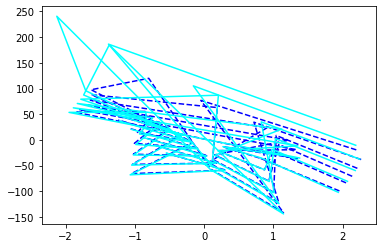

In [ ]:
# Data visualization between Test and Predicted data for the time-series data of a few sample datapoints

y_pred1 = model(X_physics_test)


# Reversing standardization
y_pred1 = y_pred1 * std_y.to('cpu') + mean_y.to('cpu')

y_pred1 = y_pred1.detach().numpy()

plt.plot(y_pred1[0:50:5, :, 0], y_pred1[0:50:5, :, 1], color='blue', ls='--')
plt.plot(y_test[0:50:5, :, 0], y_test[0:50:5, :, 1], color='cyan')

In [ ]:
model_PINN.eval()
model_PINN.to('cpu')
y_predict_test = model_PINN(X_physics_test[:1000, :, :]).detach().numpy()
y_predict_test = y_predict_test * (std_y).detach().numpy() + (mean_y).detach().numpy()
y_test = y_physics_test[:1000, :, :] * (std_y).detach().numpy() + (mean_y).detach().numpy()

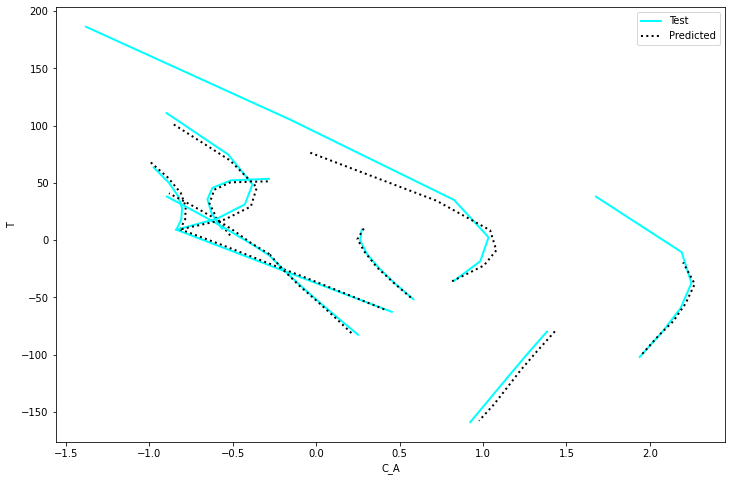

In [ ]:
# Data visualization between Test and Predicted data for the time-series data of the first 10 sample datapoints

y_test = y_physics_test[:1000, :, :]

plt.figure(figsize=(12, 8))
for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2, label='Test')
        plt.plot(y_predict_test[i, :, 0], y_predict_test[i, :, 1], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2)
        plt.plot(y_predict_test[i, :, 0], y_predict_test[i, :, 1], color='black', lw=2, ls=':')


plt.xlabel("C_A")
plt.ylabel("T")
plt.legend()
plt.show()